# Unsupervised Learning Analysis of US Arrests Dataset

Load in necessary libraries

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Exploration of Data and Preprocessing

Load in data.
This dataset contains for rape, murder and assault arrest per 100,000 residents in each of the 50 US States in 1973. It also includes a column with the % of the population of that state that live in urban areas.

In [70]:
df = pd.read_csv('UsArrests.csv', index_col=False)
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


Before going any further with the preprocessing I'm going to rename the 'City' column to 'State' as that is what it's actually displaying. 

In [92]:
df = df.rename(columns={'City': 'State'})
df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


It is useful to examine what kind of data we'll be working with so we will use the .info() function to display the data types of each column. It appears that we are working with continuous data types for the statistics and catagorical data for the states which is what we want. 

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


Let's start by summarising the statistical properties of each column.

In [72]:
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose()
selected_stats

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


We also need to check if there are any missing values in the dataset. Luckily in this dataset there are none so we don't need to perform any imputation of missing values.

In [73]:
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


Let's plot a histogram to visualise the distribution of the observations for each feature. As we can see there doesn't appear to be any noticable gaps in the distribution of observations which is good. 

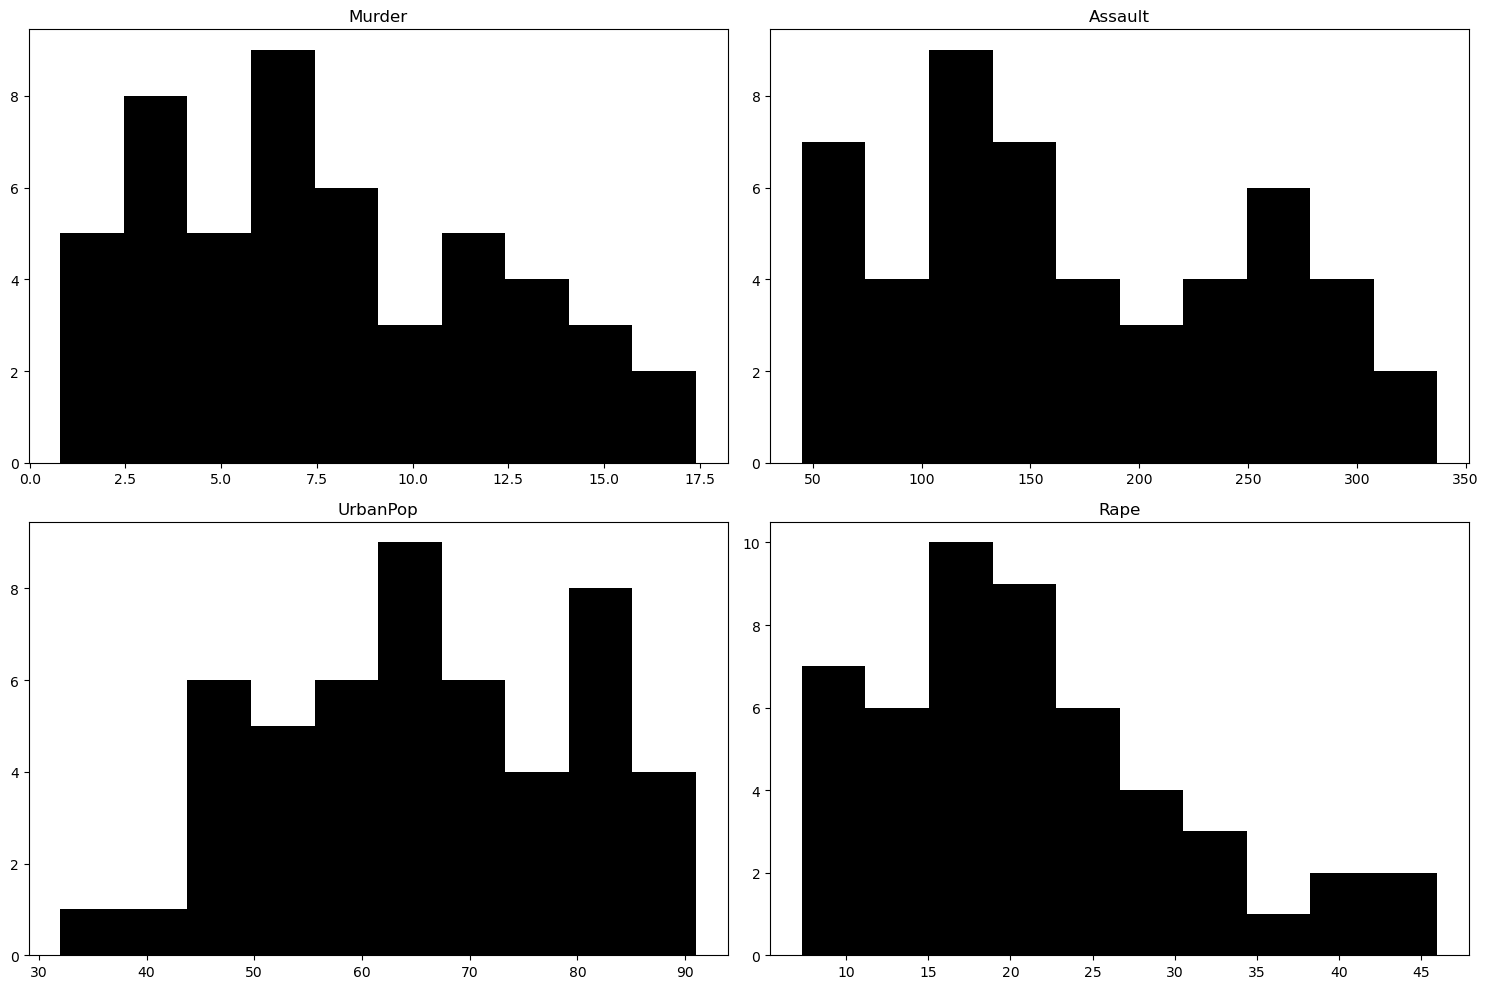

In [74]:
histograms = df.hist(color='black', grid=False, figsize=(15, 10))
plt.tight_layout()
plt.show()

Let's compile all the tabular information we have so far into a single dataframe so we can more easily see what's going on. 

In [75]:
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary

,missing,mean,std,min,max
City,0,NaN,NaN,NaN,NaN
Murder,0,7.788,4.355510,0.8,17.4
Assault,0,170.760,83.337661,45.0,337.0
UrbanPop,0,65.540,14.474763,32.0,91.0
Rape,0,21.232,9.366385,7.3,46.0


At first glance you can clearly see the large range between the smallest min and the largest max values in the Murder and Assault columns. Also, the UrbanPop column is a percentage and the other features are all out of 100,000, so scaling the data is going to be important to stop it from impacting the analysis disproportionately.

# Correlation Analysis and Visualisation

In [100]:
state = df['State']
corr_df = df.drop(['State'],axis=1).corr()
labels = corr_df.columns

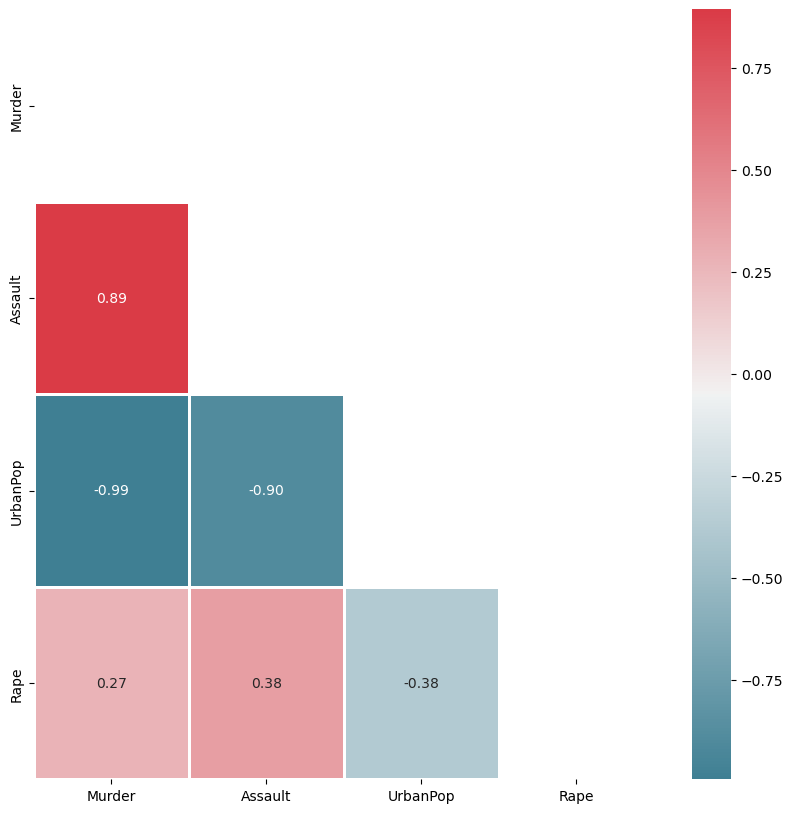

In [101]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df):
  # get correlations
  corrs = df.corr()

  # pick appropriate palette for heatmap

  # Plot figsize
  fig, ax = plt.subplots(figsize=(10, 10))

  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.show()

corr_heatmap(corr_df)

In the plot there is a clear linear correlation between the strongly correlated variables. Those coloured in red or darker blue. Variables which are positively correlated are red: an increase in one corresponds to an increase in the other, while negatively correlated variables are blue: a decrease in one means an increase in the other.

From the correlation plot it is evident that there is a strong positive correlation between Murder and Assault. This is intuitive as all murders are also assaults. So you would imagine that and increase in murders would suggest and increase in the number of arrests for assault. 
In fact, there is a positive correlation between all three of the crimes, which is something you would expect. 

There is a negative correlation between the three crime features and the UrbanPop feature. This suggests that as the percentage of the population living in densely populated urban areas increases, the number of reported Rapes, Assaults and Murders decreases. This is another intuitive correlation. As you could imagine, it is probably easier to commit and get away with a crime in an area where the population is more spread out and there's a lower chance of being seen by a witness etc.  

It will be interesting to see what happens when we apply PCA to this data as all of the features appear to be quite strongly correlated, whether it be positively or negatively. 

# PCA

Assigning the features to a temporary variable. 

In [102]:
X = df[['Murder','Assault','UrbanPop','Rape']].values.reshape(-1,4)

Scaling and transforming the data to account for the difference in feature proportions, i.e. out of 100,000 or as a %.

In [103]:
std_scaler = StandardScaler()
std_scaler.fit(X)

X = std_scaler.fit_transform(X)

Fitting the model. 

In [104]:
pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


In [105]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Standard deviation: [1.59 1.   0.6  0.42]
Proportion of Variance Explained: [0.62 0.25 0.09 0.04]
Cumulative Proportion: [2.53 3.54 3.9  4.08]


# Biplot Visualisation

In [112]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()
    
    fig.set_size_inches(10, 6)

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = state[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley), size=8)

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

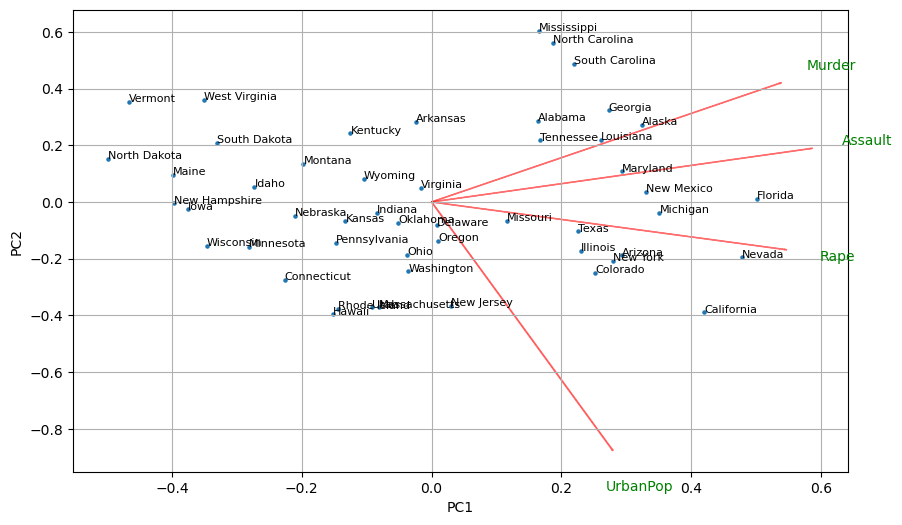

In [113]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(city))
plt.show()

Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors. From the biplot we can see that the first principal component has grouped the all of the crimes together and assigned them similar importances. It seems to summarise overall crime rate for that state. The second principal component is dominated by the UrbanPop feature. This component appears to summarise the population distribution. 

States that are on the right hand side of the graph are states where the instances of assault, rape and murder per 100,000 are highest and the opposite is true for states on the left of the graph. 

In [84]:
pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.535899,0.418181
1,Assault,0.583184,0.187986
2,UrbanPop,0.278191,0.872806
3,Rape,0.543432,0.167319


We can see that Murder, Assault and Rape share roughly equal importances in the first principal component while UrbanPop appears to dominate importance in the second principal component. 

Text(0.5, 1.0, 'Cumulative Explained Variance')

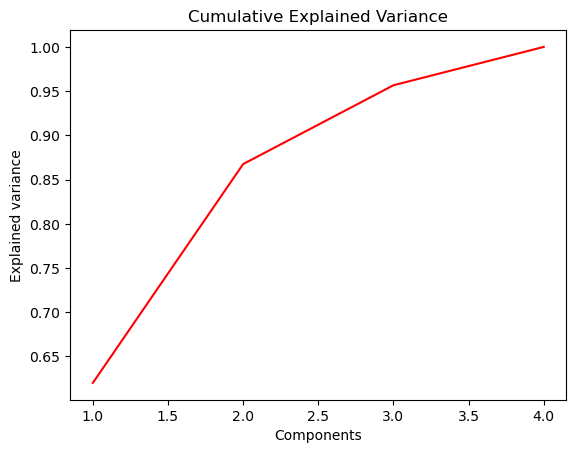

In [114]:
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

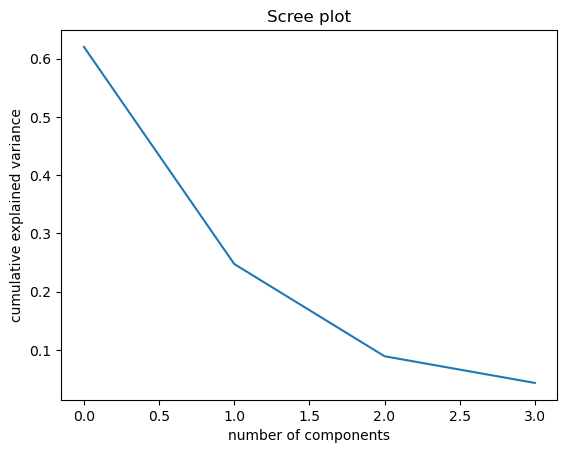

In [115]:
# Scree plot
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

From the scree and cumulative variance plots you can see that over 85% of the variance can be explained by the first two principal components. We can therefore use these to perform cluster analysis. So we have started with four features and using dimensionality reduction have gotten it down to two.

In [118]:
pca_df = pd.DataFrame(X_trans[:,0:2], index = df.index)
pca_df.head()

,0,1
0,0.985566,1.133392
1,1.950138,1.073213
2,1.763164,-0.745957
3,-0.141420,1.119797
4,2.523980,-1.542934


# Hierarcical Clustering

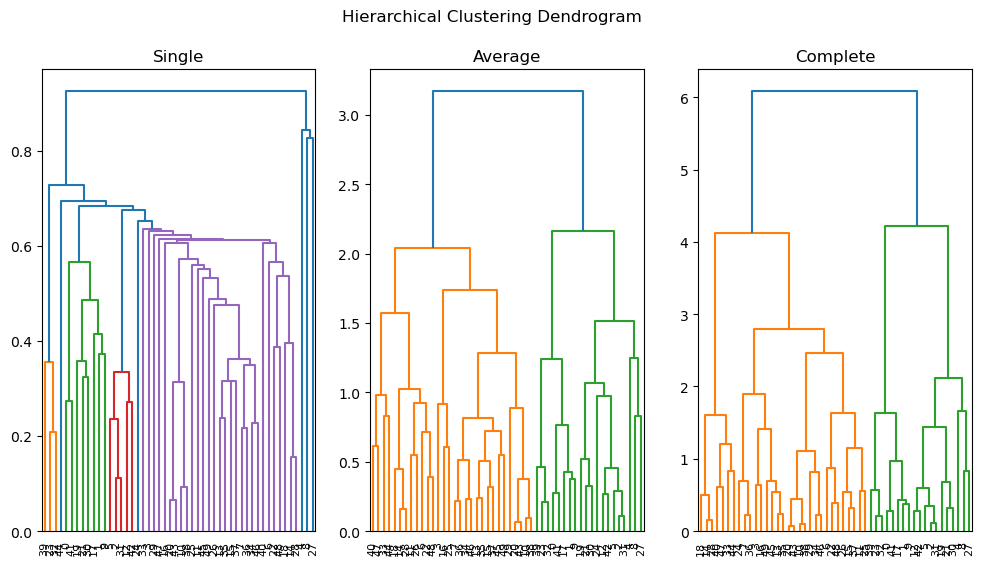

In [122]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
fig.set_size_inches(12, 6)
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

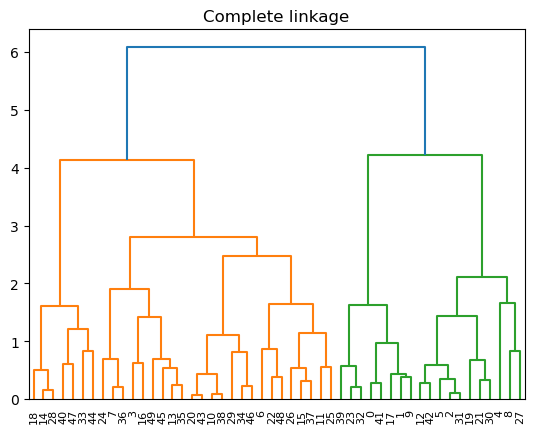

In [123]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

# K-means Clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


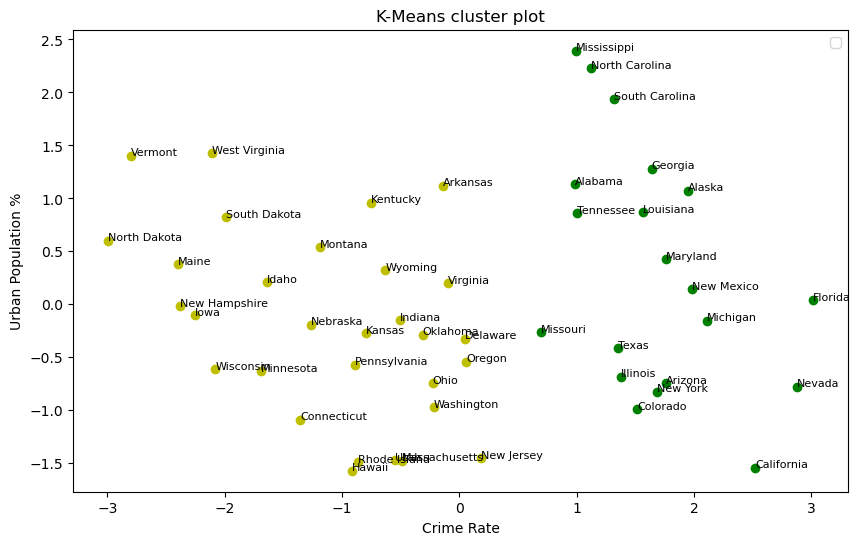

In [130]:
x = X_trans[:,0]
y = X_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
colours = 'yg'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i])

for i in range(0,len(x)):
        txt = city[i]
        ax.annotate(txt, (x[i], y[i]), size=8)
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Crime Rate")
ax.set_ylabel("Urban Population %")
ax.legend()

Both the hierarchical clustering and K-means clustering have came up with two main clusters of states. These states appear to be the same as those that we split either side of the biplot we made earlier. It appears then that these two clustering techniques have also split the data into states with high and low crime rates. States on the right of the x-axis have a higher crime rate than states further left of the x-axis. The same is true for the hierarchical clustering plot. The green cluster on the right represents high crime-rate states and the orange cluster represents low crime-rate states. The y-axis of the k-means plot corresponds to the UrbanPop feature. States higher up the axis have a lower urban population percentage and vice-versa. 